In [41]:
from pyuvdata import UVData
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import h5py
import scipy
from scipy import stats

In [9]:
uv = UVData()
uv.read('zen.2459122.48015.mini.sum.uvh5')
data = uv.data_array
print('This data array has shape:')
print('(# baselines*times, # spectral windows, # frequencies, # polarizations)')
print(np.shape(data))

This data array has shape:
(# baselines*times, # spectral windows, # frequencies, # polarizations)
(13320, 1, 1536, 1)


In [34]:
antenna1 = 14
antenna2 = 14
data = uv.get_data(antenna1,antenna2)

In [37]:
datarr = []
pairs = uv.get_antpairs()
pairs[0][1]

for i in range(666):
    ant1 = pairs[i][0]
    ant2 = pairs[i][1]
    dat = abs(uv.get_data(ant1, ant2))
    for j in range(1536):
        datarr.append(dat[0][j])
print(len(datarr))

1022976


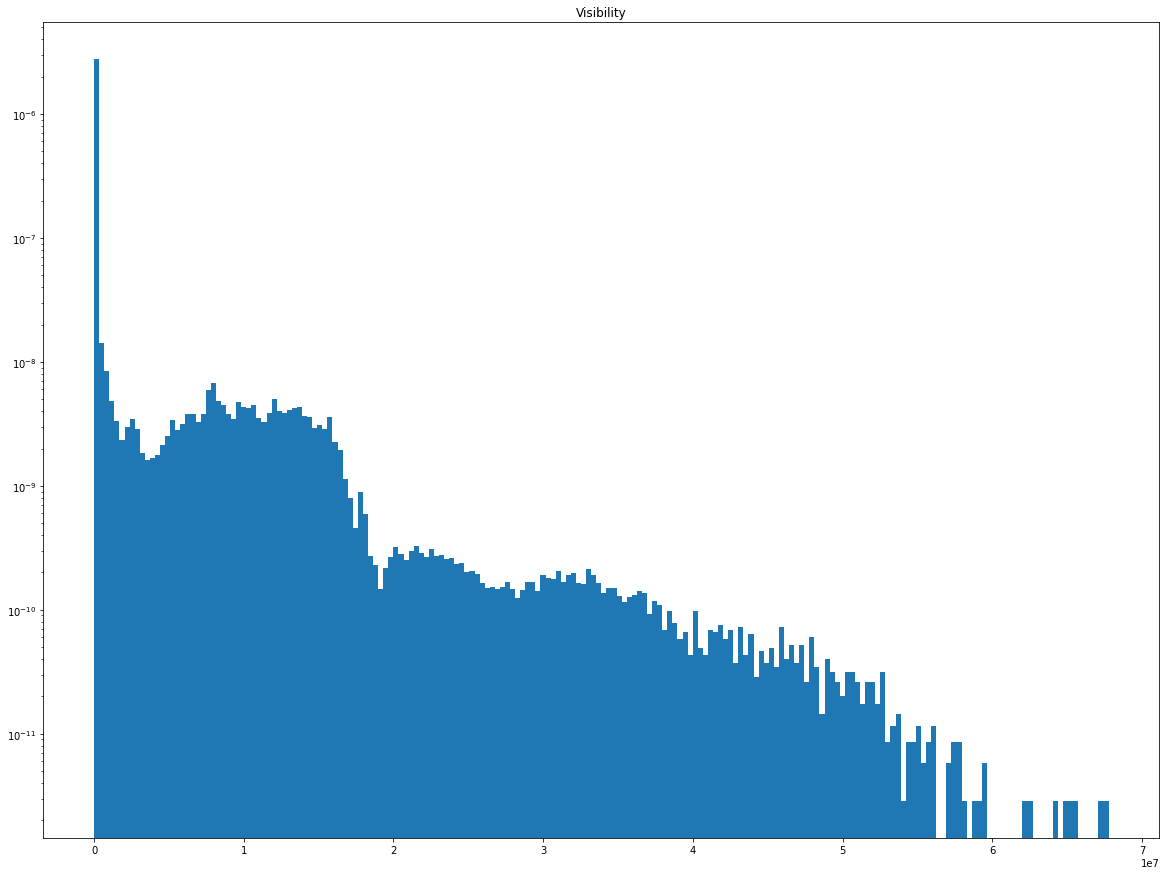

In [52]:
plt.hist(datarr, density = True, bins=200)
plt.yscale('log')
plt.title('Visibility')
plt.show()

### Problem 1

Determine 5sigma threshold

In [53]:
prob5sigma = 1 - 1/(3.5e6)
print('5 Sigma Value',stats.gamma.ppf(q = prob5sigma, a = 1, loc = 0, scale = 1e7))

5 Sigma Value 150682735.2659742


### Problem 2

#### Part A

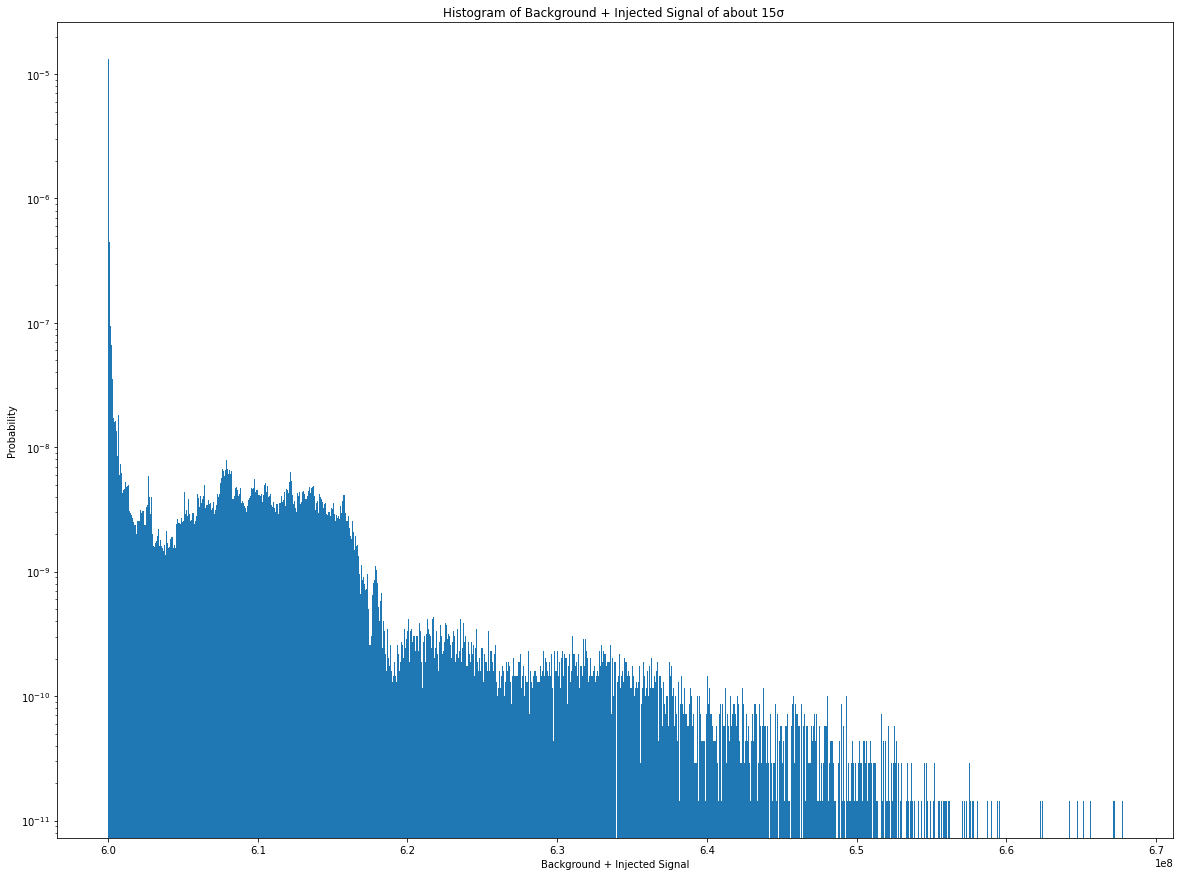

In [55]:
sigknown = 6e8
dat2 = []
for i in range(1022976):
    dat2.append(datarr[i]+sigknown)
plt.hist(dat2, density = True, bins = 1000)
plt.yscale('log')
plt.xlabel('Background + Injected Signal')
plt.ylabel('Probability')
plt.title('Histogram of Background + Injected Signal of about 15σ ')
plt.show()

#### Part B
Biased signal